<div style="height:100px">
    <div style="float: left"><img src='../images/osr-logo.png' width=150px /></div>
    <div style="float: left; margin-left:30px"><span style="font-weight: normal; font-size: 30pt; color:#666666">密码工程实验指引</span></div>
    <img src='../images/osr-line.jpg' style="width:100%; height: 5px" />
</div>


# 侧信道采集控制示例 

## 实验目的

通过实验，实现侧信道曲线的采集和存储。

## 实验要求

- 将AES加密程序下载烧写到 `OSR-Mega2560`；
- 使用osrtoolkit示波器模块和波形存储类采集能量曲线。

## 实验环境需求

- **硬件需求**
    + OSR-Mega2560
    + Pico 3206D示波器
- **软件需求**
    + Arduino IDE
    + python osrtoolkit库
- **采集环境搭建**

<img src='../images/SCASetup.png' width=500 />

## 初始化示波器和存储模块

### 导入osrtoolkit示波器模块和波形存储类

In [1]:
from osrtoolkit.oscilloscope import Pico3000
from osrtoolkit.trace import ETSStorer

### 配置示波器控制模块

In [3]:
pico = Pico3000()  # 声明pico示波器对象
pico.form  # 打开pico示波器配置界面

## 与 TOE 进行通信

In [5]:
import serial
import numpy as np
import time

In [7]:
mega = serial.Serial('com11', 115200, timeout=1)

In [8]:
def get_meta():
    p = np.random.randint(0, 256, 16, dtype=np.uint8)
    send = p.tobytes()
    mega.write(send)
    recv = mega.read(16)
    c = np.frombuffer(recv, dtype=np.uint8)
    return p, c

## 构建验证函数，在采集过程中对加密结果进行验证(非必须)

In [9]:
from Crypto.Cipher import AES

In [10]:
key = bytes([0x00, 0x01, 0x02, 0x03, 
    0x04, 0x05, 0x06, 0x07, 
    0x08, 0x09, 0x0a, 0x0b, 
    0x0c, 0x0d, 0x0e, 0x0f])

In [11]:
aes = AES.new(key,AES.MODE_ECB)

In [12]:
def verify(p, c):
    c_correct = aes.encrypt(p.tobytes())
    if c.tobytes() == c_correct:
        return True
    else:
        return False

验证一次meta数据

In [13]:
p,c = get_meta()
verify(p, c)

True

## 触发示波器采集曲线并查看

### 单次采集

In [14]:
import matplotlib.pyplot as plt

In [15]:
plt.rcParams['figure.figsize'] = [20,4]  # 调整图片尺寸

In [25]:
pico.arm()  # 将示波器置于等待触发模式，等待一次触发时间进行采集

True

In [26]:
get_meta()  # 控制TOE进行加密，完成对示波器的触发

(array([ 45, 128,  27, 136, 101,  32, 107, 119, 123, 169,  11, 177,   8,
        176, 107, 107], dtype=uint8),
 array([ 16, 111, 120, 164, 219, 198,  13, 142,  61, 115, 128, 243, 206,
        164, 130, 222], dtype=uint8))

In [27]:
trs = pico.acquire_samples()  # 从pico示波器取回数据

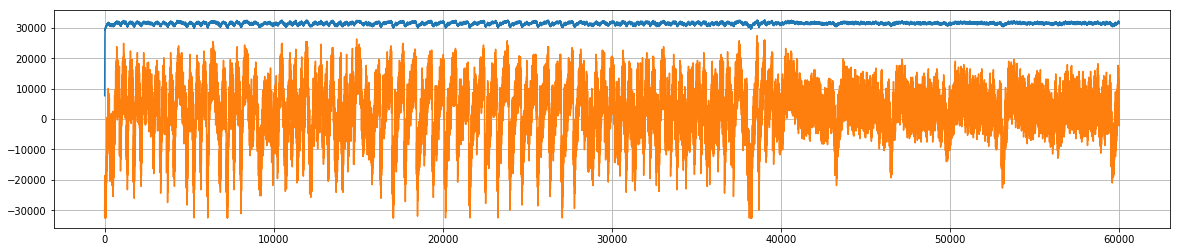

In [28]:
plt.plot(trs[0][0])
plt.plot(trs[1][0])
plt.grid()
plt.show()

### secquence采集

In [29]:
pico.arm()  # 将示波器置于等待触发模式，等待一次触发时间进行采集

True

In [30]:
for i in range(pico.sequence_num):
    get_meta()# 控制TOE进行加密，完成对示波器的触发

In [31]:
trs = pico.acquire_samples()  # 从pico示波器取回数据

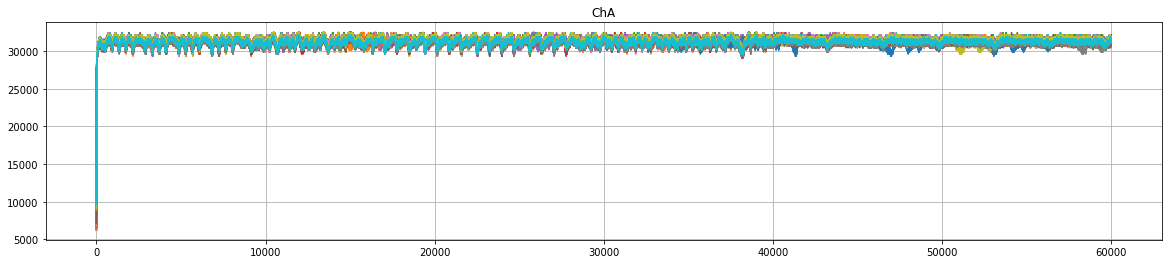

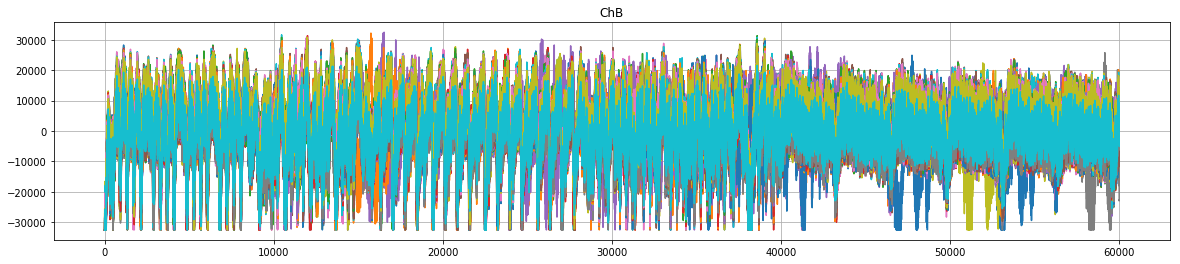

In [32]:
plt.plot(trs[0].T)
plt.grid()
plt.title('ChA')
plt.show()

plt.plot(trs[1].T)
plt.grid()
plt.title('ChB')
plt.show()

In [33]:
pico.sequence_num

100

## 波形存储

### 配置波形存储类

In [36]:
ets = ETSStorer('AES128_mega.ets', open_type='w')  # open_type = 'w' or 'a'，如果已经存在文件， 'w' 将覆盖, ‘a’ 将在原文件进行追加 

Overwrite?(y/n): y


### 以secquence模式采集1 万条曲线

In [37]:
from tqdm import tnrange
import time

for i in tnrange(100):
    # 采集一个secquence的数据
    pico.arm()
    plaintext = np.empty((pico.sequence_num, 16), dtype=np.uint8)
    ciphertext = np.empty((pico.sequence_num, 16), dtype=np.uint8)
    flag = True
    for j in range(pico.sequence_num):
        m = get_meta()
        if not verify(m[0], m[1]):
            flag = False
            break
        plaintext[j] = m[0]
        ciphertext[j] = m[1]
    if not flag:
        flag = True
        print('ERROR')
        continue
    time.sleep(0.05)  # 这里必须对示波器进行一定的延迟后再进行数据拉取操作，以响应示波器时间
    trs = pico.acquire_samples()
    data = {'meta':{'plaintext': plaintext, 'ciphertext': ciphertext}, 'samples': trs}
    ets.update(data)
ets.finish()

## 读取波形并查看

In [60]:
import scared

In [40]:
ths = scared.traces.read_ths_from_ets_file('AES128_mega.ets')

### 访问meta

In [42]:
p = ths[0:10].plaintext
print(p)

[[100 116 167   3  37 121 208 139 126  83 142 209   5 232  77 112]
 [100 116 167   3  37 121 208 139 126  83 142 209   5 232  77 112]
 [184 120  12 216 154 212 102 156 180 156  79 176  57  80 139 159]
 [184 120  12 216 154 212 102 156 180 156  79 176  57  80 139 159]
 [ 23 198 210 122 132  52  86  16 235  94  20  73 193 236 220 248]
 [ 23 198 210 122 132  52  86  16 235  94  20  73 193 236 220 248]
 [ 53 225 103 225 225 104 122  94 150 139 172 210  90   4  22  42]
 [ 53 225 103 225 225 104 122  94 150 139 172 210  90   4  22  42]
 [194 225 112 138 247 194 230 200 199 143  52  89 211 231 172  38]
 [194 225 112 138 247 194 230 200 199 143  52  89 211 231 172  38]]


In [45]:
c = ths[0:10:2].ciphertext
print(c)

[[137 228 185 241  59 207  66 165 231 122 183 178 159 252 210 243]
 [113  34 248 119 172  41 132 222  38 214 214  50  74 106  37 246]
 [ 98  73 129  34 198 104  61  35  62 228 242 210 248  32  93  74]
 [ 72  62 239 207 146 177  90  91 142 150  29 232 110 232 223 168]
 [233  99  57 100 171  97  58  57 178  88 250 106  79   2   5 210]]


### 访问samples

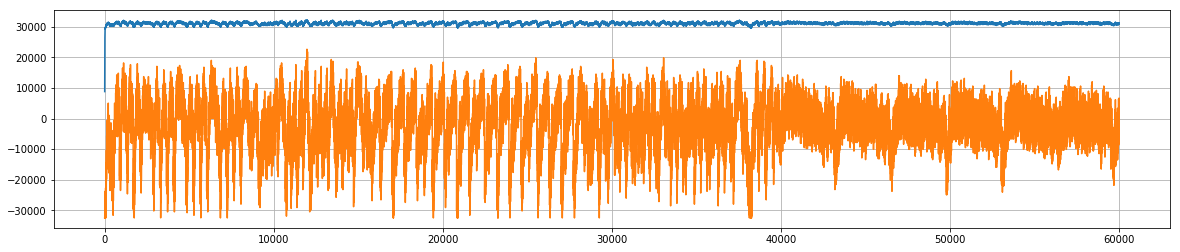

In [47]:
plt.plot(ths[0].samples)
plt.plot(ths[1].samples)
plt.grid()
plt.show()

<img src='../images/osr-line.jpg' style="width:100%; height: 5px" />
<span style="font-weight: normal; font-size: 20pt; color:#666666">联系我们</span>

<span style="font-weight: normal; font-size: 18pt; color:#666666">深圳市纽创信安科技开发有限公司 (Open Security Research, Inc.)</span>
<div>
    <div style="float: left">
        <img src="../images/osr-code.png" width='150px'>
    </div>
    <div style="float: left; margin-left:30px">
        <h5>网址: <a href="https://www.opsefy.com/">www.opsefy.com</a> </h5>
        <h5>邮箱: <a href="mailto:sales@opsefy.com">sales@opsefy.com</a></h5>
        <h5>电话: +86 755 8695 0263</h5>
        <h5>
            地址：深圳市南山区粤海街道高新南 10 道深圳湾生态园 12 栋裙楼 8 楼 29-31 室<br/>
                 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
                北京市海淀区中关村东路 66 号世纪科贸大厦 B 座 2703 室
        </h5>
    </div>
</div>
